Coords těžiště 276,74 se nachází: 5
Coords těžiště 77,76 se nachází: 1
Coords těžiště 198,168 se nachází: 1
Coords těžiště 72,206 se nachází: 5
Coords těžiště 302,251 se nachází: 1

Celková hodnota mincí: 13 Kč


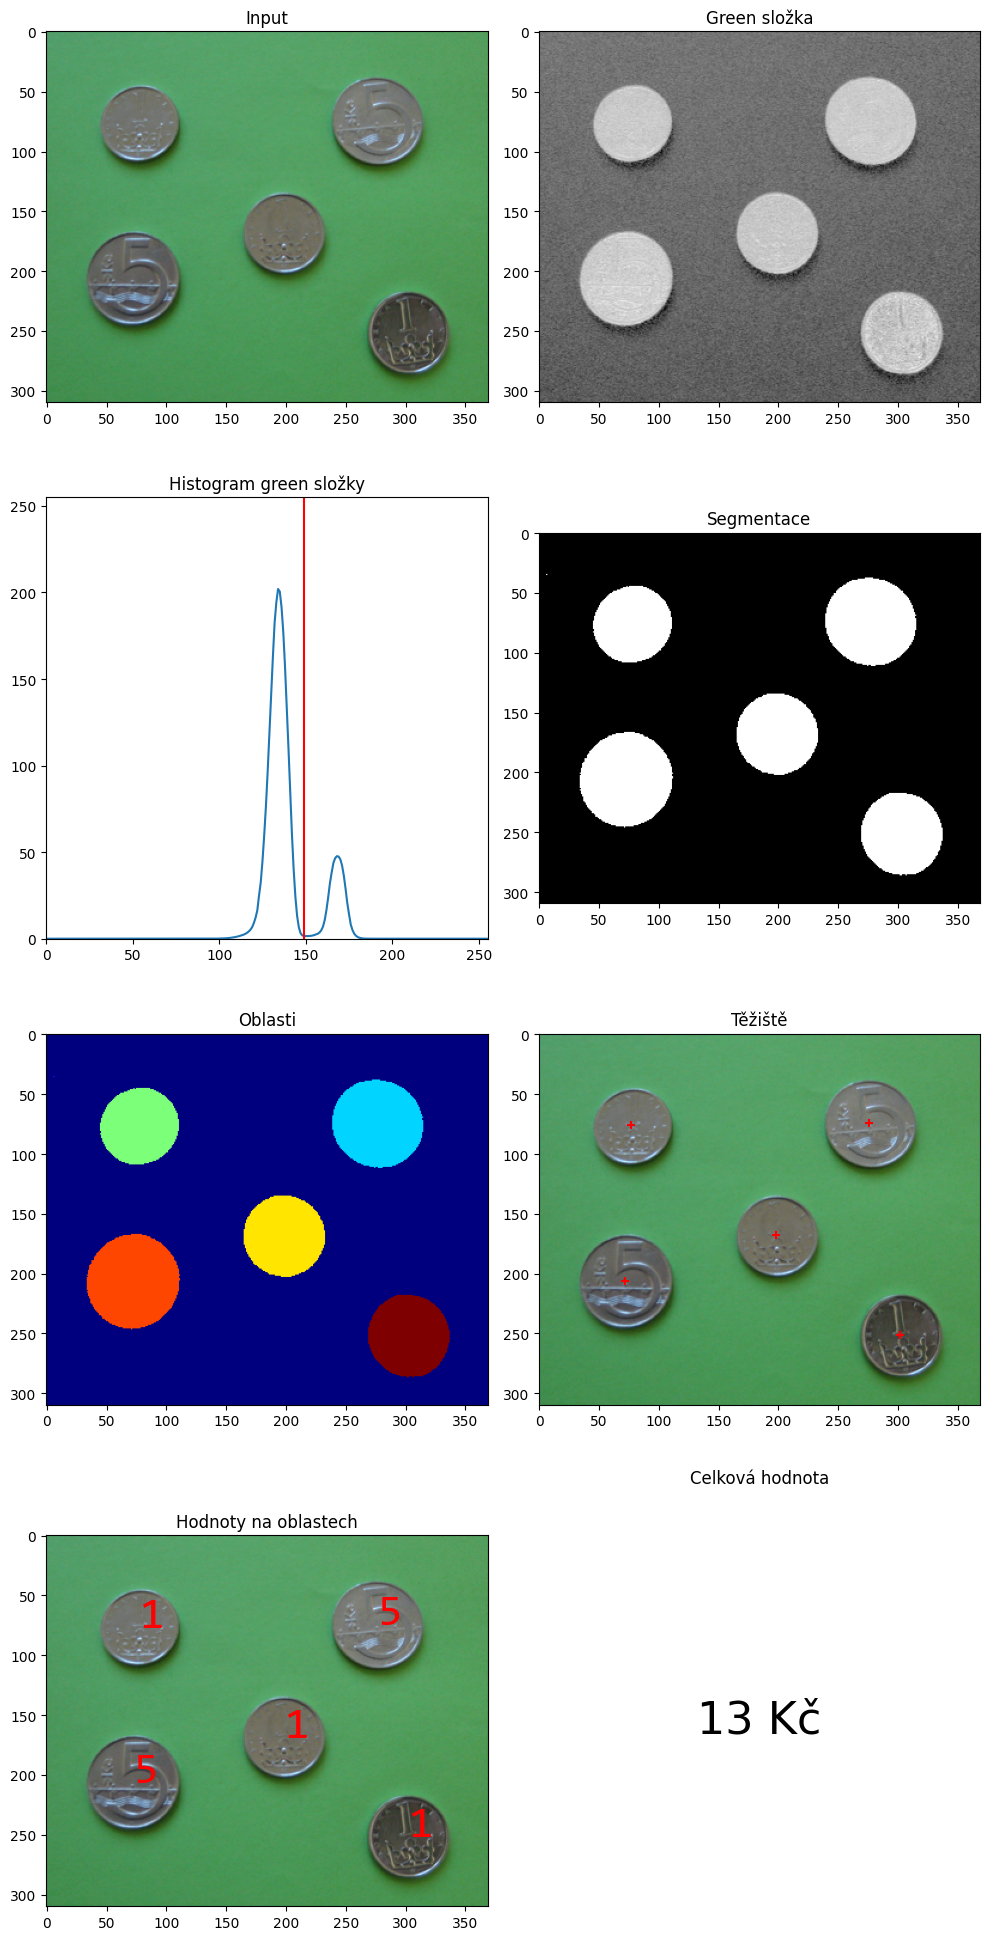

In [13]:
# made by Martin "Granc3k" Šimon, Jakub "Parrot2" Keršláger
from pathlib import Path
from collections import deque
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Calcne se histogram pro určení prahu pro segmentaci
def calc_histogram(image, smoothing):
    histogram = cv2.calcHist([image], [0], None, [256], [0, 256])
    normalized = histogram / np.max(histogram) * 255
    flattened = np.ndarray.flatten(normalized)
    smoothed = np.convolve(flattened, np.ones(smoothing)/smoothing, mode='same')
    return smoothed

# Findne první lokální minimum v histogram -> práh pro segmentaci
def calc_threshold(array):
    threshold = np.where((array[1:-1] < array[0:-2]) * (array[1:-1] < array[2:]))[0]
    threshold = threshold[0]
    return threshold

# Calcne těžiště oblast
def calc_center_of_mass(image):
    points = []
    for i in range(2, np.max(image) + 1):  # index 1 se obvykle vynechává – pozadí
        copy = np.zeros_like(image)
        copy[image == i] = 1
        moments = cv2.moments(copy, True)
        # Převod momentů na souřadnice těžiště
        points.append([int(moments['m10'] / moments['m00']), int(moments['m01'] / moments['m00'])])
    return points

# Určí hodnotu mince na základě počtu pixelů v oblasti -> vyhází se ze zadání s 4000 pixely
def calc_region_values(image, points):
    values = []
    for point in points:
        region_number = image[point[1]][point[0]]
        number_of_pixels = len(np.argwhere(image == region_number))
        values.append({
            'point': point,
            'value': 5 if number_of_pixels > 4000 else 1
        })
    return values

# Impl. barvení oblastí pomocí BFS - 0 dá k pozadí a ostatní čísla k oblastem (záleží kolik bude oblastí)
def bfs_coloring(image):
    rows, cols = image.shape
    visited = np.zeros_like(image).astype('bool') # visitnuté pixely
    colors = np.zeros_like(image).astype('uint8') # barvy oblastí
    directions = [(0, 1), (0, -1), (1, 0), (-1, 0)] # definuje směry pro BFS

    def is_valid(x, y):
        return 0 <= x < rows and 0 <= y < cols

    def bfs(x, y, color):
        queue = deque([(x, y)])
        visited[x][y] = True
        colors[x][y] = color

        while queue:
            current_x, current_y = queue.popleft()
            for dx, dy in directions:
                new_x, new_y = current_x + dx, current_y + dy
                if all([
                    is_valid(new_x, new_y),
                    not visited[new_x][new_y],
                    image[new_x][new_y] == 1
                ]):
                    queue.append((new_x, new_y))
                    visited[new_x][new_y] = True
                    colors[new_x][new_y] = color

    color_count = 0
    for i in range(rows):
        for j in range(cols):
            if not visited[i][j] and image[i][j] == 1:
                color_count += 1
                bfs(i, j, color_count)

    return colors

# === Main ===
_image = cv2.imread(Path("./data/cv07_segmentace.bmp").as_posix())
_image = cv2.cvtColor(_image, cv2.COLOR_BGR2RGB)

# Split na barevné kanály a calc pozadí
red = np.float32(_image[:, :, 0])
green = np.float32(_image[:, :, 1])
blue = np.float32(_image[:, :, 2])
g = 255 - ((green * 255) / (red + green + blue))

# Histogram a segmentace pomocí prahu
g_hist = calc_histogram(g, 10)
threshold = calc_threshold(g_hist)

segmented_image = g.copy()
segmented_image[segmented_image < threshold] = 0
segmented_image[segmented_image >= threshold] = 1

# Findne souvislé oblasti -> Calcne jejich těžiště -> Přiřadí jim 1 Kč nebo 5 Kč
regions = bfs_coloring(segmented_image)
points = calc_center_of_mass(regions)
coin_values = calc_region_values(regions, points)

# Calc sumy
total_value = sum(coin['value'] for coin in coin_values)

# === Final print ===
rows, cols = 4, 2  # 4 řádky, 2 sloupce
plt.figure(figsize=(10, 20))  # vyšší okno

plt.subplot(rows, cols, 1)
plt.imshow(_image)
plt.title("Input")

plt.subplot(rows, cols, 2)
plt.imshow(g, cmap="gray")
plt.title("Green složka")

plt.subplot(rows, cols, 3)
plt.xlim(0, 255)
plt.ylim(0, 255)
plt.axis('square')
plt.plot(g_hist)
plt.vlines([threshold], 0, 255, "red")
plt.title("Histogram green složky")

plt.subplot(rows, cols, 4)
plt.title("Segmentace")
plt.imshow(segmented_image, cmap="gray")

plt.subplot(rows, cols, 5)
plt.title("Oblasti")
plt.imshow(regions, cmap='jet')

plt.subplot(rows, cols, 6)
plt.title("Těžiště")
plt.imshow(_image)
plt.scatter(*zip(*points), marker="+", color="red")

plt.subplot(rows, cols, 7)
plt.title("Hodnoty na oblastech")
plt.imshow(_image)
for coin in coin_values:
    point = coin["point"]
    value = coin["value"]
    plt.text(point[0], point[1], value, color="red", fontsize=32, fontfamily="Consolas")
    print(f"Coords těžiště {point[0]},{point[1]} se nachází: {value}")

plt.subplot(rows, cols, 8)
plt.axis('off')
plt.title("Celková hodnota")
plt.text(0.5, 0.5, f"{total_value} Kč", fontsize=32, ha='center', va='center')

print(f"\nCelková hodnota mincí: {total_value} Kč")

plt.tight_layout()
plt.show()
